In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import sys
from IPython.display import HTML, display, Latex
import numpy as np
import copy as copy
from collections import defaultdict 
import networkx as nx
import string
import math

# Simple Temporal Network #
## Should you warn the *Big Bad Guy Wearing Black* or should you just try to *escape*?

As a diligent Empire Space Station employee there are a few tasks you would like to complete if possible before fleeing the doomed Space Station. In the Control room you can warn the *Big Bad Guy Wearing Black* that the rebels have destroyed the Space Station, but it will take $[time_{radio}^-,time_{radio}^+]$ parsecs. The Long-Range Radio has been out of service for awhile now, but it would be best to fix it and broadcast to the Emporer the Space Station's fate. In order to fix it you must go to the Droid Room and activate an Astromech R2 unit (which can take $[time_{activate}^-,time_{activate}^+]$) and then bring the droid to the Control Room to to fix the Long-Range radio which will take $[time_{repair}^-,time_{repair}^+]$ parsecs. This Droid can also be used to fly your escape ship, so having a droid fly you away from the Space Station is preferable over flying yourself. If possible you would also like to dowload the Empire's Secret Files for safe keeping, this can be done in the control room while the droid is repairing the Long-Range Radio or you are Radioing your status, but will take $[time_{download}^-,time_{download}^+]$ parsecs. To get a safe distance away from the Space Station's destruction, you must fly away for $[time_{fly}^-,time_{fly}^+]$ parsecs before the Space Station is destroyed at $time_{explosion}$.

**Set of Actions**
1. Go to Control Room
2. Go to Droid Room
3. Go to Starship Hangar

**Set of Tasks:**
1. Radio *Big Bad Guy Wearing Black*
2. Activate Droid
3. Repair Long-Range Radio with Droid
4. Download Empire's Secret Files
5. Fly away from Space Station




## Graphs

We can graph our schedule as Tasks being Nodes and Time Constraints being edges
<br/>
<center>
<img src="Task Graph.PNG" width="50%" height="50%" />
</center>   
<br/>
Here we see a Task can take any amount of time between it's lower and upper bounds (in this case between 10 and 20 minutes). We can divide this Task into two nodes, a **Start** and **End** event for each Task, and capture it's time constraints as edges just as we did in the previous graph.

**STN Graph**
<br/>
<center>
<img src="Event Graph.PNG" width="100%" height="100%" />
</center>   
<br/>
An edge with upper and lower bounds effectively captures networks information, but is not very useful for scheduling. We can infer the constraints through computing shortest paths between nodes (events) in the graph, but to do that we must **convert the STN Graph into a Distance Graph**.

To Convert an STN Graph into a Distance Graph
1. Upper bounds map to out going arcs
2. Lower bounds map to in coming arcs with weights negated.

**Distance Graph**
<br/>
<center>
<img src="Distance Graph.PNG" width="100%" height="100%" />
</center>   
<br/>

*Why does a distance graph work?*

If we imagine time as distance, we can encode upper bounds as use outgoing arcs with a weight on the upper bound. With this one edge from A to B, we enforce the two events connected to have a scheduled time difference of $ A + u.b. \geq B $

We can also encode lower bounds as incoming arcs with a negative weight on the lower bound. With this one edge from B to A, we enforce the two events connected to have a scheduled time difference of $ B - l.b. \geq A $. Together both edges encode $ B - l.b. \geq A \geq B - u.b. $.

For example: in the Distance Graph above, if 'Task A start' is scheduled for t=5 parsecs, then the outgoing edge from 'Task A Start' enforces 'Task A End' to be scheduled at a time lees than 25, $ 5 + 20 \geq B $. Also, the incoming edge to 'Task A Start' from 'Task A End' enforces 'Task A End' to be scheduled at a time greater than 15, $ B - 10 \geq 5 $ (Of note one shortcut we use is the lower bound to 'START' only needs to come from the start event of every task, and the upper bound from 'START' only needs to go to the end event of every task.)

In a network, even if two Nodes are not directly connected by an edge, a path that connects them needs constraints propagated for all Nodes of the network to obey all temporal constraints. This propagation of constraints can be done by by finding the shortest path in the network from any Node to every other Node, also know as All-Pairs-Shortest-Path (APSP) Problem. 

Solving the shortest route from any one Node to any other Node is a well understood problem such as using Floyd-Warshal Algorithm on a distance graph, thus using a distance graph representing the STN is very useful.

The following theorem shows that we can check feasibility of the STP, and obtain its minimal domain, by just computing all-to-all shortest paths.

#### Theorem: Let $T$ be the given STP and $G_d$ be its distance graph. Then the following hold: 
 1. $T$ is consistent iff $G_d$ has no negative cycles.
 2. The minimal domain for the constraint $C_{ij}$ is given by $D_{ij}^{\ast} = [-d_{ji}, d_{ij}]$. In particular, the minimal domain for variable $X_i$ is given by $D_{0i}^{\ast} = [-d_{i0}, d_{0i}]$.


**Proof:** To see the first part, let $G_d$ contain a negative cycle $C$, given by $C = (i_0 = i, i_1, i_2, \ldots i_n = i)$. Applying the constraints $X_j - X_i \leq u_{ij}$ we get  
<center>
$0 = X_i - X_i \leq \sum_{k=1}^{n} u_{i_{k} i_{k-1}} = l(C)$,
</center>
which is the length of the cycle. Since $l(C) < 0$, the above equation results in a contradiction. This implies that there can be no feasible assignment to the variables. Thus, the problem is infeasible.

On the other hand, if $G_d$ has no negative cycle then we know that the shortest path between each pair of nodes is well defined. Then, let $d_{0i}$ denote the length of the shortest path from node $0$ to node $i$. Due to the shortest path property, we must have $d_{0j} \leq d_{0i} + u_{ij}$, which is nothing but the constraint $d_{0j} - d_{0i} \leq u_{ij}$. Since, this holds for all $(i,j)$ we conclude that the assignment $s = (d_{01}, d_{02}, \ldots d_{0n})$ is a feasible solution. Therefore, $T$ is consistent. **QED**



### <a name="desc"></a> Description of Temporal Constraints

Firstly, note that given any two tasks, say X and Y, they can only be related in the following eight ways: 1. X occurs before Y, 2. X meets Y, 3. X and Y overlap, 4. X and Y start at the same time, 5. X occurs during Y, 6. X finishes exactly when Y finishes, 7. X and Y are equal, i.e. they both start and end together, and 8. X and Y are completely disjoint. This was first observed in [Allen 1983]. These eight types of constraints are referred to as qualitative temporal relationships.   
<br/>
<center>
<img src="Table.jpg" width="50%" height="50%" />
</center>   
<br/>
Qualitative relationships are hard to encode directly. However, if we encode each task, say X, as a time interval $[a_X, b_X]$ then each of the above qualitative relationships can be represented as relation constraints relating $a_X$ to $b_X$. For example, "X occurs before Y" can be written down as $b_X \leq a_Y$, while "X occurs during Y" can be written down as $a_Y \leq a_X$ and $b_X \leq b_Y$; here, the tasks X and Y are encoded as time constraints $[a_X, b_X]$ and $[a_Y, b_Y]$, respectively. 

It is to be noted that the 8th temporal relation, namely, "X and Y are completely disjoint" has to be expressed as a disjunctive constraint: either $b_X \leq a_Y$ or $b_Y \leq a_X$. All other temporal relations can be expressed as simple metric constraints, without disjunctions.

To formulate such a problem as a STN, each task is decomposed into two events, a start event and an end event. These are related by duration constraints: for example, the requirement that radioing Darth Vader - I mean *The Big Bad Guy Wearing Black* takes at least 10 parsecs could be expressed by the following duration constraint:
$$radio_+ - radio_- \geq 10 parsecs$$
Then, the above qualitative relationships are encoded as relation constraints. For example, the constraint that the repairs must be completed strictly before radioing could be expressed by the following relational constraint:
$$radio_- > repair_+$$

These constraints form the STN, which can then be expanded into a directed distance graph.

## Helper functions for Encoding functions

In [2]:
# For each event in schedule there must be two nodes to express its start and end
def make_NodeList(events):
    # node List begins with Start for starting node X_0
    nodeList = ['Start']
    for e in events:
        nodeList.append(e + ' Start')
        nodeList.append(e + ' End')
    return nodeList

# Make a 2D Matrix to hold weights on a directional graph
def make_Graph(nodeList):
    sz = len(nodeList)
    # Values initialized as infinity as default of no edge is a weight of infinity
    return np.matrix(np.ones((sz,sz))*np.inf)

# Find duration of traversal
def find_DurTraversal(loc1,loc2,dur_traversal):
    # Try looking up both combinations of events in dictionary
    try:
        dur = dur_traversal[(loc1,loc2)]
        return dur
    except KeyError:
        try:
            dur = dur_traversal[(loc2,loc1)]
            return dur
        except KeyError:
            # If unable to find in dictionary it is assumed loc1 == loc2
            return 0

## Helper functions for Printing

In [3]:
def print_Schedule(schedule,events):
    # Sort events by arrive time
    l = [ (schedule[1+i*2], i) for i in range(len(events)) ]
    l.sort()
    sorted_l,perm = zip(*l)    
    # Find longest event title
    max_str_len = 0
    for event in events:
        if len(event) > max_str_len:
            max_str_len = len(event)
    # Create string for format with longest event title
    s = '0: <{}'.format(max_str_len+3)
    s = '{'+s+'}'
    # Print Arrival times
    for p in perm:
        print(s.format(events[p]),"Arr: ",schedule[1+p*2],"\tDep: ",schedule[1+p*2+1])
    print()
        
def print_STN(events,graph):
    print('-------------STN Graph-------------')

    # Create Node List from events given
    nodeList = make_NodeList(events)
          
    # Find longest event title
    max_str_len = 0
    for node in nodeList:
        if len(node) > max_str_len:
            max_str_len = len(node)
    # Create string for format with longest event title
    s1 = '0: <{}'.format(max_str_len+3)
    s1 = '{'+s1+'}'
    s2 = '{0: <16}'
    # Print Structure
    print(s1.format('From Node:'),s2.format("[ l ,  u ]:"),"To Node:")
           
    # All start nodes must begin after the originating node
    for i in range(len(graph)):
        first_entry = True
        for j in range(i,len(graph)):
            if i != j and graph[j,i] != np.inf and graph[i,j] >= 0:
                if first_entry:
                    first_entry = False
                    print(s1.format(nodeList[i]),s2.format(str([abs(graph[j,i]),graph[i,j]])),nodeList[j])
                else:
                    print(s1.format(""),s2.format(str([abs(graph[j,i]),graph[i,j]])),nodeList[j])
        print()

def print_DistGraph(events,graph):
    print('-------------Distance Graph-------------')

    # Create Node List from events given
    nodeList = make_NodeList(events)
          
    # Find longest event title
    max_str_len = 0
    for node in nodeList:
        if len(node) > max_str_len:
            max_str_len = len(node)
    # Create string for format with longest event title
    s1 = '0: <{}'.format(max_str_len+3)
    s1 = '{'+s1+'}'
    s2 = '{0: <16}'
    # Print Structure
    print(s1.format('From Node:'),s2.format("Edge Weight:"),"To Node:")
           
    # All start nodes must begin after the originating node
    for i in range(len(graph)):
        first_entry = True
        for j in range(len(graph)):
            if i != j and graph[i,j] != np.inf:
                if first_entry:
                    first_entry = False
                    print(s1.format(nodeList[i]),s2.format(str(graph[i,j])),nodeList[j])
                else:
                    print(s1.format(""),s2.format(str(graph[i,j])),nodeList[j])
        print()

## Encode Functions

Functions to take siutation with actions, events, and time constraints in a simple directed graph

Simple directed graph = 2D Matrix with a value for each weight in each direction

In [4]:
# All start nodes must start after the node 'Start'
def encode_Start(graph,startLoc,events,locations,dur_t):
    for (X_Idx,event) in enumerate(events):
        loc2 = locations[X_Idx]
        dur = find_DurTraversal(startLoc,loc2,dur_t)
        graph[1+X_Idx*2,0] = -dur
        
# Fly end node must end before the 'time_explosion'
def encode_End(graph,events,time_end):
    for (X_Idx,event) in enumerate(events):
        if event == 'Fly':
            graph[0,1+X_Idx*2+1] = time_end
            graph[1+X_Idx*2+1,0] = 0
            break


# Encode event time ranges
def encode_Event(X_Idx,graph,time_range):
    # Upper bounds map to outgoing arcs
    graph[1+X_Idx*2  ,1+X_Idx*2+1] = time_range[1]
    # Lower bounds to incoming arcs with weights negated
    graph[1+X_Idx*2+1,1+X_Idx*2]   = -time_range[0]
    
# Encode qualitative interval relations as relations on time points
def encode_Relationship(events,graph,X,Y,dur,relation):
    # Get Index of X and Y events for indexing in the graph
    try:
        X_Idx = events.index(X)
        Y_Idx = events.index(Y)
    except ValueError:
        # If events do not exist then constraint is irrelevent
        return
    # X_+ < Y_- + dur   =>   [dur,inf]
    # X_+ = Y_- + dur   =>   [dur,dur]   
    # BEFORE
    if relation == 'BEFORE':
        graph[1+Y_Idx*2,1+X_Idx*2+1]   = -dur
    # MEETS
    elif relation == 'MEETS':
        graph[1+Y_Idx*2  ,1+X_Idx*2+1] = -dur
        graph[1+X_Idx*2+1,1+Y_Idx*2]   =  dur
    # OVERLAPS
    elif relation == 'OVERLAPS':
        graph[1+X_Idx*2+1,1+Y_Idx*2]   = -dur
        graph[1+Y_Idx*2+1,1+X_Idx*2]   = -dur
    # STARTS
    elif relation == 'STARTS':
        graph[1+X_Idx*2  ,1+Y_Idx*2]   = -dur
        graph[1+Y_Idx*2  ,1+X_Idx*2]   =  dur
        graph[1+Y_Idx*2+1,1+X_Idx*2+1] = -dur
    # DURING  
    elif relation == 'DURING':
        graph[1+X_Idx*2  ,1+Y_Idx*2]   = -dur
        graph[1+Y_Idx*2+1,1+X_Idx*2+1] = -dur
    # FINISHES
    elif relation == 'FINISHES':
        graph[1+X_Idx*2  ,1+Y_Idx*2]   = -dur
        graph[1+Y_Idx*2+1,1+X_Idx*2+1] = -dur
        graph[1+X_Idx*2+1,1+Y_Idx*2+1] =  dur       
    # EQUALS
    elif relation == 'EQUALS':
        graph[1+X_Idx*2  ,1+Y_Idx*2]   = -dur
        graph[1+Y_Idx*2  ,1+X_Idx*2]   =  dur
        graph[1+Y_Idx*2+1,1+X_Idx*2+1] = -dur
        graph[1+X_Idx*2+1,1+Y_Idx*2+1] =  dur
        

# Scheduling

## Step 1: Expose Implicit Constraints in STN

Input STN and use All-Pairs-Shortest-Path of graph to create a decomposable STN

In [5]:
# Prepare the initial Directional Graph for APSP as respresented by a 2D Matrix
def make_Initial_DGraph(events,locations,dur_t,time_ranges,time_end,relationships):
    # Create Node List from events given
    nodeList = make_NodeList(events)
    # Create Initial Matrix of graph edge weights
    graph = make_Graph(nodeList)
    
    # All start nodes must begin after the originating node
    encode_Start(graph,'X_0',events,locations,dur_t)
    
    # Fly end node must end before the time of Space Station explosion
    encode_End(graph,events,time_end)
    
    # Encode relationships between different events
    for (X,Y,relation) in relationships:
        loc1 = locations[events.index(X)]
        loc2 = locations[events.index(Y)]
        dur = find_DurTraversal(loc1,loc2,dur_t)
        encode_Relationship(events,graph,X,Y,dur,relation)
    
    # Encode difference between start and end for each events two nodes
    for (X_Idx,event) in enumerate(events):
        encode_Event(X_Idx,graph,time_ranges[X_Idx])
        
    # Make diagonal values 0
    for i in range(0,len(nodeList)):
        graph[i,i] = 0
    
    return graph

# Floyd Warshal Algorithm to produce APSP
#    Take minimum distance over all triangles and update graph
def APSP(graph):
    sz = len(graph)
    for k in range(0,sz):
        for i in range(0,sz):
            for j in range(0,sz):
                graph[i,j] = min(graph[i,j],graph[i,k] + graph[k,j])
    return graph

# Step 1.5 Feasibility Check

No point in decomposing the STN graph for a schedule if the plan is infeasible. 

# Consistency Check

#### Theorem: Let $T$ be the given STP and $G_d$ be its distance graph. Then the following hold: 
 1. $T$ is consistent iff $G_d$ has no negative cycles.
 2. The minimal domain for the constraint $C_{ij}$ is given by $D_{ij}^{\ast} = [-d_{ji}, d_{ij}]$. In particular, the minimal domain for variable $X_i$ is given by $D_{0i}^{\ast} = [-d_{i0}, d_{0i}]$.


**Proof:** To see the first part, let $G_d$ contain a negative cycle $C$, given by $C = (i_0 = i, i_1, i_2, \ldots i_n = i)$. Applying the constraints $X_j - X_i \leq u_{ij}$ we get  
<center>
$0 = X_i - X_i \leq \sum_{k=1}^{n} u_{i_{k} i_{k-1}} = l(C)$,
</center>
which is the length of the cycle. Since $l(C) < 0$, the above equation results in a contradiction. This implies that there can be no feasible assignment to the variables. Thus, the problem is infeasible.

On the other hand, if $G_d$ has no negative cycle then we know that the shortest path between each pair of nodes is well defined. Then, let $d_{0i}$ denote the length of the shortest path from node $0$ to node $i$. Due to the shortest path property, we must have $d_{0j} \leq d_{0i} + u_{ij}$, which is nothing but the constraint $d_{0j} - d_{0i} \leq u_{ij}$. Since, this holds for all $(i,j)$ we conclude that the assignment $s = (d_{01}, d_{02}, \ldots d_{0n})$ is a feasible solution. Therefore, $T$ is consistent. **QED**

## Other Algorithms

1. Johnson's Algorithm
2. FIFO Label Correcting

## Feasibility Check

Floyd Warshall Algorithm is used to see if a negative cycle exists in the STN graph. If a negative cycle does exist then STN is infeasible

*** 
**Pseudo code of all pair shortest path Floyd-Warshall algorithm**

for i = 1 to n:  $d_{ii}=0$;   *% Initializing* 

for i, j = 1 to n: $d_{ij}=u_{ij}$;   *% Initializing* 

for k  = 1 to n: 

&emsp; for i, j = 1 to n:  
&emsp;&emsp;     $d_{ij} =min(d_{ij}, d_{ik} + d_{kj})$ *% Take the minimum distance over all triangles*  
***

In [6]:
# Use Floyd Warshall Algorithm to detect if a negative cycle is present
def negCycle(graph):
    sz = len(graph)
    # Store distance of every node to every node
    dist = np.matrix(np.ones((sz,sz)))
    for i in range(0,sz):
        for j in range(0,sz):
            dist[i,j] = graph[i,j]
            
    # Test all intermediate vertices
    for k in range(0,sz):
        for i in range(0,sz):
            for j in range(0,sz):
                # If node k is on the shortest path from node i to j then update the value of dist[i,j]
                if dist[i,k] + dist[k,j] < dist[i,j]:
                    dist[i,j] = dist[i,k] + dist[k,j]
    
    # Negative Cycle exists if the shortest path from a node to itself is negative
    for i in range(0,sz):
        if dist[i,i] < 0:
            return True
        
    return False

# Consistency Check

Running the Negative Cycle detector code is redundant as in Step 1 we already have APSP calculated from the Distance Graph. 

If STN is inconsistent, the Distance Graph formed by finding APSP will have a negative value along diagonal.

*But why does this work?*

In the distance matrix, the value along diagonals represents the distance of the shortest path from Node i to Node i, as in the shortest distance of a Node to itself. 

When a negative cycle exists, it if from the temporal constraints on events being infeasible, as the edge from B to A with weighting of the negative lower bound is greater than a path from A to B, the sum of upper bounds (and possibly negative lower bounds) that connects B to A. This Negative Cycle implies that an event needs to start before it's start time, which is impossible, and thus the whole STN is infeasible if any Negative Cycle is found in the graph. So if the shortest distance from Node i to itself is negative, then a negative cycle exists, and a diagonal value along the APSP will be negative.  

**Example: An infeasible STN and Distance Graph**
<br/>
<center>
<img src="Inf Graph.PNG" width="75%" height="75%" />
</center>   
<br/>
This produces the APSP
<br/>
<center>
<img src="Inf APSP.PNG" width="25%" height="25%" />
</center>   
<br/>
For this infeasible STN, a negative cycle is created in the distance graph and the shortest path from Node $s_s$ to itself is negative

In [7]:
def consistency_Check(graph):
    sz = len(graph)
    for i in range(0,sz):
        # If diagonal values are negative, then the graph is inconsistent
        if graph[i,i] < 0:
            return False
    return True

## Negative Cycle Indication Function##
After a negative Cycle is detected, the edges in the Distance Graph that make this negative cycle are found and displayed

In [8]:
# Get neighbors of current Index in graph
def neighbors(g,curr_Idx):
    l = []
    for i in range(len(g)):
        if g[curr_Idx,i] != np.inf:
            l.append(i)
    return l

# Recursive function to find path to goal_Idx in graph with a negative cost
def find_negCycle(g,goal_Idx,path,cost):
    curr_Idx = path[-1]
    for i in neighbors(g,curr_Idx):
        if i == goal_Idx:
            if cost + g[curr_Idx,i] < 0:
                # Path to goal with negative cost has been found
                new_path = copy.copy(path)
                new_path.append(i)
                return new_path
        elif not (i in path):
            new_g = copy.copy(g)
            new_path = copy.copy(path)
            new_path.append(i)
            new_cost = cost + g[curr_Idx,i]
            p = find_negCycle(new_g,goal_Idx,new_path,new_cost)
            if p != None:
                return p
    return None

# Print negative cycly in graph
def print_negCycle(events,g,graph):
    print('-------------Negative Cycle-------------')
    sz = len(graph)
    
    path = []
    # Find Cycle beginning and end
    goal_Idx = -1
    for i in range(sz):  
        if g[i,i] < 0:
            # Start and End of negative cycle found
            path.append(i)
            goal_Idx = i
            break
    
    # Search for negative cycle path
    path = find_negCycle(graph,goal_Idx,path,0)
    
    # Create Node List from events given
    nodeList = make_NodeList(events)
          
    # Find longest event title
    max_str_len = 0
    for node in nodeList:
        if len(node) > max_str_len:
            max_str_len = len(node)
    # Create string for format with longest event title
    s1 = '0: <{}'.format(max_str_len+3)
    s1 = '{'+s1+'}'
    s2 = '{0: <16}'
    # Print Structure
    print(s1.format('From Node:'),s2.format("Edge Weight:"),"To Node:")
           
    # All start nodes must begin after the originating node
    cost = 0
    for (Idx,i) in enumerate(path[0:-1]):
        # Get the Index of the next node on the negative cycle path
        j = path[Idx+1]
        cost += graph[i,j]
        print(s1.format(nodeList[i]),s2.format(str(graph[i,j])),nodeList[j])
        print()
    
    # Print total cycle cost (should be negative)
    s3 = '0: >{}'.format(max_str_len)
    s3 = '{'+s3+'}'
    print(s3.format('Total'),'= ',cost)
    print()
    

In [9]:
# Find Schedule by incrementally tightening feasible intervals as commitments are greedily made
def STN_Decomposition(graph):
    sz = len(graph)
    # Initialize  time assignments and intervals
    node_schedule  = []
    node_intervals = []
    for i in range(0,sz):
        # Initially no events have a scheduled time and intervals are unknown
        node_schedule.append(None)
        node_intervals.append([-np.inf,np.inf])
    
    # Tighten feasible intervals until all nodes are committed on the schedule
    #    Because variables can be assigned in any order, and all nodes are 
    #    neighbors of every other node, they are assigned a time in sequential order
    for i in range(0,sz):
        if i != 0:
            # Schedule is assigned as the earliest feasible bound
            node_schedule[i] = node_intervals[i][0]
            node_intervals[i] = [node_schedule[i],node_schedule[i]]
        else:
            # Begin scheduling with start node at t = 0
            node_schedule[0] = 0
            node_intervals[0] = [0,0]
            
        # Adjust following Intervals after recent assignment
        for j in range(i+1,sz):
            node_intervals[j][0] = max(node_intervals[j][0],node_schedule[i]-graph[j,i])
            node_intervals[j][1] = min(node_intervals[j][1],node_schedule[i]+graph[i,j])
            # Check for infeasibility
            if node_intervals[j][0] > node_intervals[j][1]:
                return None
            
    return node_schedule
        
    

# Step 2: Greedy Scheduling

Now that we have formed an APSP Matrix from the Distance Graph, we can use this to calculate the time interval for possible event scheduling.
<table> <tr>
<td> <img src="APSP Time Interval.PNG" width="100%" height="100%" /> </td> 
<td> <img src="Ex Dist Graph.PNG" width="100%" height="100%" /> </td>
</tr> </table>
Event $X_0$ is a special Node as it is the reference Node that that all other Nodes will be scheduled from. In our code we treat event 'Start' as Node $X_0$ and automatically schedule it to be time zero.

The first row represents the value of the shortest path from Node $X_0$ to every Node i. Since edges goring FROM $X_0$ TO any Node are the upper bounds of temporal constraints, the value of the shortest path from Node $X_0$ to Node i is the minimum of all upper bounds (the earliest conjunction of upper bounds). Since it is the shortest time gap, or minimum upper bound, all other upper bounds any other Node pairings in this Network might impose are also satisfied. 

The first column represents the value of the shortest path from every Node to Node $X_0$. Since edges going from a Node i to $X-0$ are the negative lower bounds of temporal constraints, the value of the shortest path from Node $X_0$ to Node i is the minimum of all negative lower bounds (the maximum of all lower bounds). Since it is the longest time gap of lower bound conjunctions, or max lower bound, all other lower bounds any other Node pairings in this Network might impose are also satisfied.  

APSP getting all shortest paths from this reference Node, $X_0$, is essentially performing Forward Checking throughout the entire Distance Graph. Thus the first row holds all the latest times of an event from the 'Start' and the first column holds all the earliest times.

*So now we have intervals for feasible scheduling, what next?*

Now we can greedily schedule an exact time for each event, using the psuedo code below:

$ for \quad E \quad in \quad EventList $

$ \quad time(E) \leftarrow earliest \space value \space in \space Bound_E \space (B[E][0]) $

$ \quad for \space X_i \space in \space unassignedNeighbors(E) $

$ \quad \quad B[X_i] = B[X_i] \space \land \space (time(E) + distGraph[E,X_i]) $

**To note:**
1. We begin with the 'Start' event be scheduled at time t = 0 as our reference Node.

2. We choose the earliest possible time value of an events scheduable range (the left bound). **We could choose any value within the event bounds** though as the APSP has performed Forward Checking and all values greater than the maximum lower bound and minimum upper bound are feasible for the Network.  

3. **We can schedule the events in any order**. Any time we schedule an event we tighten that events range of lower bound and upper bounds to that exact time value scheduled. Because we already have an event's time bounds consistent with all edges from the APSP, we propogate this update to all other unecheduled events to tighten the events' schedulable range to only values that keep the network feasible. No back checking is necessary as the earlier values were chosen from a proven feasible range, and future event's are forced to stay consistent with those scheduling decisions by the previously mentioned bound propagation.  




## Greedy Scheduling Functions

Input a Decomposable STN created in Step 1 to create a Schedule from Greedy assignment and neighbor propagation

Greedy assignment = earliest possible scheduling within interval

• Input: APSP d-graph (decomposable STN)  
• Output: Schedule (Assignment to X, consistent with STN)  
• Property: Can assign variables **in any order**  
• Algorithm: Greedy assignment + neighbor propagation (similar to forward checking)

Pseudo code for **time point assignments + neighbor propagation**:

***
if C is an unassigned event:  
&emsp;   While C:  
&emsp; &emsp; *%The value in B[C] can pick arbitrarily, if it works in the following neighbor propagation, you win*  
&emsp;&emsp; $ time(C)$ = value in its bound $B[C]  $   
&emsp;&emsp;    for Xi in unassigned neighbors(C):  
&emsp;&emsp;&emsp;      % Incrementally tighten feasible intervals as commitments are made  
&emsp;&emsp; &emsp;     $B[X_i] = B[X_i] \cap (time(C) + d(C,X_i))$  
***

# Given Actions, Events, and Temporal Constraints, is this plan feasible?

Below is an ambitous plan to complete all possible tasks before escaping, the plan can become feasible or infeasible by scaling the ranges of values for travel and task completion.

In [10]:
def make_Schedule(events,locations,dur_t,time_ranges,time_end,relationships,display=True):
    # Make Initial directional graph
    graph = make_Initial_DGraph(events,locations,dur_t,time_ranges,time_end,relationships)
        
    if display:
        # Print STN graph
        print_STN(events,graph)

        # Print Distance graph
        print_DistGraph(events,graph)
    
    # Find All Pairs Shortest Path for graph
    g = APSP(copy.deepcopy(graph))

    # Check feasibility of plan
    if consistency_Check(g):
        # Decompose STN for schedule
        return STN_Decomposition(g), graph
    else:
        if display:
            print_negCycle(events,g,graph)
        return None, None

-------------STN Graph-------------
From Node:        [ l ,  u ]:      To Node:
Start             [5.0, inf]       Fly Start
                  [0.0, 39.0]      Fly End
                  [5.0, inf]       Radio Start
                  [5.0, inf]       Activate Start
                  [5.0, inf]       Repair Start
                  [5.0, inf]       Download Start

Fly Start         [5.0, 5.0]       Fly End


Radio Start       [1.0, 10.0]      Radio End


Activate Start    [5.0, 5.0]       Activate End

Activate End      [7.0, inf]       Repair Start

Repair Start      [5.0, 5.0]       Repair End
                  [0.0, 0.0]       Download Start

Repair End        [0.0, inf]       Download End

Download Start    [10.0, 10.0]     Download End


-------------Distance Graph-------------
From Node:        Edge Weight:     To Node:
Start             39.0             Fly End

Fly Start         -5.0             Start
                  5.0              Fly End
                  -7.0             Ra

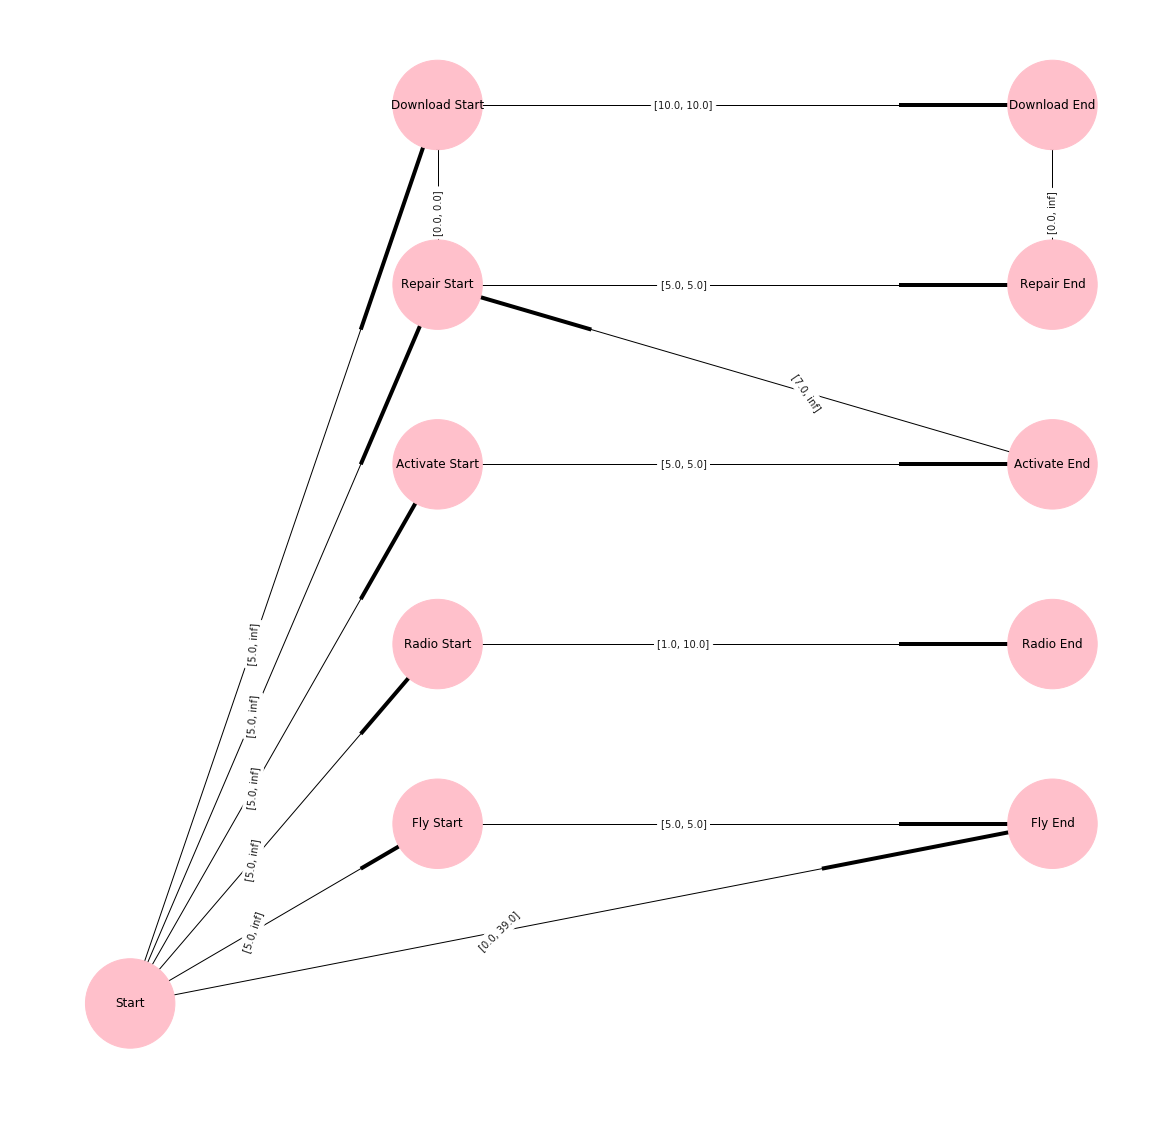

In [12]:
dur_t= {('X_0','Droid Room')          : 5,
        ('X_0','Control Room')        : 5,
        ('X_0','Hangar')              : 5,
        ('Droid Room','Control Room') : 7,
        ('Droid Room','Hangar')       : 10,
        ('Control Room','Hangar')     : 7}
events      = ['Fly'   ,'Radio'       ,'Activate'  ,'Repair'      ,'Download']
locations   = ['Hangar','Control Room','Droid Room','Control Room','Control Room'] 
time_ranges = [[5,5]   ,[1,10]         ,[5,5]       ,[5,5]         ,[10,10]]
time_explosion = 39

relationships= [('Radio'   ,'Fly'     ,'BEFORE'),
                ('Repair'  ,'Radio'   ,'BEFORE'),
                ('Activate','Fly'     ,'BEFORE'),
                ('Activate','Radio'   ,'BEFORE'),
                ('Activate','Repair'  ,'BEFORE'),
                ('Download','Fly'     ,'BEFORE'),
                ('Repair'  ,'Download','STARTS')]

# Attempt to make a schedule with plan
schedule, graph = make_Schedule(events,locations,dur_t,time_ranges,time_explosion,relationships)

def print_Graph(schedule, events, graph):

    nodeList = make_NodeList(events)
    
    graphnodes = []
    idx = 0
    ischedule = 0
    dy = 30
    for node in nodeList:
        #xpos = 5*schedule[ischedule]
        xpos = (1+ischedule)%2*20 +10
        idx = idx+1
        ypos = max([0, math.floor(idx/2)])*dy
        ischedule = ischedule + 1
        graphnodes.append((node, (xpos, ypos)))
    
    graphnodes[0] = nodeList[0], (0, 0)
    
    G = nx.DiGraph()
    G.add_nodes_from(nodeList)
    
    for node, pos in graphnodes:
        #print(node, pos)
        G.node[node]['pos'] = pos
        G.node[node]['color'] = 'pink'
    
    pos = dict(graphnodes)
    #print(pos)
    
    constraints = []
    weights = []
    
    for i in range(len(graph)):
        for j in range(i,len(graph)):
            if i != j and graph[j,i] != np.inf and graph[i,j] >= 0:
                constraints.append((nodeList[i],nodeList[j]))
                weights.append(str([abs(graph[j,i]),graph[i,j]]))
    
    #print(constraints)
    #print(weights)
    
    node_color = [G.node[v]['color'] for v in G]
    
    # add edges to the graph
    for i in range(0,len(constraints)):
        u = constraints[i][0]
        v = constraints[i][1]
        G.add_edge(u,v,weight = weights[i],color = 'black')
    
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    e_labels = nx.get_edge_attributes(G,'weight')
    
    plt.figure(1,figsize=(20,20))
    nx.draw_networkx_edge_labels(G,pos, edges=edges, edge_color=colors, edge_labels=e_labels,label_pos=0.6,alpha = 0.9)
    nx.draw(G, pos, edges=edges, edge_color=colors, node_color=node_color,node_size = 8000,with_labels=True) 


    
    return None

# Print results
if schedule == None:
    print("Negative Cycle Detected")
    print("Plan is Infeasible")
else:
    print("Feasible Schedule Found!")
    print_Schedule(schedule,events)
    print_Graph(schedule, events, graph)

# Which plan is best?
Sometimes completing all the desired events is not possible. This function takes input that has been structured to include the least desirable events on the right hand side of the events list, and will return either a notification that no plans are feasible or a schedule for the best possible plan.

In [14]:
def make_Potential_Plan(e,l,dur_t,t,time_explosion,r):
    events       = copy.deepcopy(e)
    locations    = copy.deepcopy(l)
    time_ranges  = copy.deepcopy(t)
    relationships= copy.deepcopy(r)
    
    sz = len(events)
    
    # While there are still events
    while len(events) > 0:
        
        schedule, graph = make_Schedule(events,locations,dur_t,time_ranges,time_explosion,relationships,False)
        if schedule == None:
            # Remove least desired Task
            event = events.pop()
            locations.pop()
            time_ranges.pop()
            remove_Idx_List = []
            for (i,(X,Y,relation)) in enumerate(relationships):
                if X == event or Y == event:
                    remove_Idx_List.append(i)
            remove_Idx_List.reverse()
            for i in remove_Idx_List:
                relationships.pop(i)
        else:
            # Feasible Schedule found!
            print("Feasible Schedule Found!")
            print_Schedule(schedule,events)
            return schedule

In [15]:
dur_t= {('X_0','Droid Room')          : 5,
        ('X_0','Control Room')        : 5,
        ('X_0','Hangar')              : 5,
        ('Droid Room','Control Room') : 7,
        ('Droid Room','Hangar')       : 10,
        ('Control Room','Hangar')     : 7}
events      = ['Fly'   ,'Radio'       ,'Activate'  ,'Repair'      ,'Download']
locations   = ['Hangar','Control Room','Droid Room','Control Room','Control Room'] 
time_ranges = [[5,5]   ,[1,10]         ,[5,10]     ,[5,5]         ,[10,10]]
relationships= [('Radio'   ,'Fly'     ,'BEFORE'),
                ('Repair'  ,'Radio'   ,'BEFORE'),
                ('Activate','Repair'  ,'BEFORE'),
                ('Download','Fly'     ,'BEFORE'),
                ('Repair'  ,'Download','STARTS')]

# Test by moving time to escape back and forth
times_explosion = [5, 10, 20, 30, 40, 50]
#times_explosion = [38, 50]

# Attempt to make a schedule with plan
for time in times_explosion:
    print('If the explosion is occuring in %g parsecs, then:' % time)
    plan = make_Potential_Plan(events,locations,dur_t,time_ranges,time,relationships)
    if plan == None:
        print('No feasible plan found.')
        print()

If the explosion is occuring in 5 parsecs, then:
No feasible plan found.

If the explosion is occuring in 10 parsecs, then:
Feasible Schedule Found!
Fly    Arr:  5.0 	Dep:  10.0

If the explosion is occuring in 20 parsecs, then:
Feasible Schedule Found!
Radio       Arr:  5.0 	Dep:  6.0
Activate    Arr:  5.0 	Dep:  10.0
Fly         Arr:  13.0 	Dep:  18.0

If the explosion is occuring in 30 parsecs, then:
Feasible Schedule Found!
Radio       Arr:  5.0 	Dep:  6.0
Activate    Arr:  5.0 	Dep:  10.0
Fly         Arr:  13.0 	Dep:  18.0

If the explosion is occuring in 40 parsecs, then:
Feasible Schedule Found!
Activate    Arr:  5.0 	Dep:  10.0
Repair      Arr:  17.0 	Dep:  22.0
Download    Arr:  17.0 	Dep:  27.0
Radio       Arr:  22.0 	Dep:  23.0
Fly         Arr:  34.0 	Dep:  39.0

If the explosion is occuring in 50 parsecs, then:
Feasible Schedule Found!
Activate    Arr:  5.0 	Dep:  10.0
Repair      Arr:  17.0 	Dep:  22.0
Download    Arr:  17.0 	Dep:  27.0
Radio       Arr:  22.0 	Dep:  23.0
F

# Flexible Planning

When a Schedule is made it is quite rigid and a change in any execution time could cause the whole plan to fail. 

Here a greedy schedule is made, and then the user can alter the schedule by chossing the event time within the acceptable range.

## The user can enter 'q' to quit or 'g' to greedily schedule the rest of the events

In [110]:
def flexible_planning(events,locations,dur_t,time_ranges,time_end,relationships):
    nodeList = make_NodeList(events)

    # Make Initial directional graph
    graph = make_Initial_DGraph(events,locations,dur_t,time_ranges,time_end,relationships)

    # Find All Pairs Shortest Path for graph
    g = APSP(copy.deepcopy(graph))  
    
    # STN Decomposition
    sz = len(g)
    # Initialize  time assignments and intervals
    node_schedule  = []
    node_intervals = []
    for i in range(0,sz):
        # Initially no events have a scheduled time and intervals are unknown
        node_schedule.append(None)
        node_intervals.append([-np.inf,np.inf])
    
    # Tighten feasible intervals until all nodes are committed on the schedule
    #    Because variables can be assigned in any order, and all nodes are 
    #    neighbors of every other node, they are assigned a time in sequential order
    for i in range(0,sz):
        if i != 0:
            # Schedule is assigned as the earliest feasible bound
            node_schedule[i] = node_intervals[i][0]
            node_intervals[i] = [node_schedule[i],node_schedule[i]]
        else:
            # Begin scheduling with start node at t = 0
            node_schedule[0] = 0
            node_intervals[0] = [0,0]
            
        # Adjust following Intervals after recent assignment
        for j in range(i+1,sz):
            node_intervals[j][0] = max(node_intervals[j][0],node_schedule[i]-g[j,i])
            node_intervals[j][1] = min(node_intervals[j][1],node_schedule[i]+g[i,j])
            # Check for infeasibility
            if node_intervals[j][0] > node_intervals[j][1]:
                print("Plan is Infeasible")
                return None
    
    print("Initial Greedy Schedule")
    # Print previous schedule
    print_Schedule(node_schedule,events)
    
    # Sort events by arrive time
    l = [ (node_schedule[i], i) for i in range(len(nodeList)) ]
    l.sort()
    sorted_l,perm = zip(*l) 
    
    # Reassign node intervals based off of APSP Graph
    for i in range(1,sz):
        node_schedule[i] = None
        node_intervals[i] = [abs(g[i,0]),g[0,i]]
    
    # Begin changing time's of events chronologically after 'Start' event
    visited_Idx_List = [0]
    for (sort_Idx,event) in enumerate(sorted_l[1:len(sorted_l)]):
        event_Idx = perm[sort_Idx+1] 
        
        # Add index of node to be rescheduled to visited list
        visited_Idx_List.append(event_Idx)
        
        # Display information on current node that can be rescheduled
        print("Range of feasible '{}' times is [{},{}]".format(nodeList[event_Idx],node_intervals[event_Idx][0],node_intervals[event_Idx][1]))
        
        # Get user input
        old_event_time = node_schedule[event_Idx]
        print("Input 'q' to quit or 'g' to greedy schedule")
        new_event_time = input("Input new '{}' time: ".format(nodeList[event_Idx]))
        
        # Check if user wants to quit
        if new_event_time == 'q':
            print()
            print('Goodbye!')
            return None
        if new_event_time == 'g':
            print()
            print('Greedy Schedule')
            # Tighten feasible intervals until all nodes are committed on the schedule
            #    Because variables can be assigned in any order, and all nodes are 
            #    neighbors of every other node, they are assigned a time in sequential order
            for i in range(0,sz):
                # Schedule is assigned as the earliest feasible bound
                node_schedule[i] = node_intervals[i][0]
                node_intervals[i] = [node_schedule[i],node_schedule[i]]

                # Adjust following Intervals after recent assignment
                for j in range(i+1,sz):
                    node_intervals[j][0] = max(node_intervals[j][0],node_schedule[i]-g[j,i])
                    node_intervals[j][1] = min(node_intervals[j][1],node_schedule[i]+g[i,j])
                    # Check for infeasibility
                    if node_intervals[j][0] > node_intervals[j][1]:
                        print("Plan is Infeasible")
                        return None
            print_Schedule(node_schedule,events)
            return None
        else:
            # Re-cast input to a float
            new_event_time = float(new_event_time)
                    
            # Schedule new event time
            node_schedule[event_Idx] = new_event_time
            node_intervals[event_Idx] = [node_schedule[event_Idx],node_schedule[event_Idx]]
            
            # Ensure node_intervals are consistent with nodes already scheduled
            for i in range(sz):
                # Only need to check intervals of scheduled nodes
                if node_schedule[i] != None:
                    for j in range(sz):
                        node_intervals[j][0] = max(node_intervals[j][0],node_schedule[i]-g[j,i])
                        node_intervals[j][1] = min(node_intervals[j][1],node_schedule[i]+g[i,j]) 
        print()
                        
    # Print final schedule made
    print_Schedule(node_schedule,events)
    return None

In [112]:
flexible_planning(events,locations,dur_t,time_ranges,50,relationships)

Initial Greedy Schedule
Feasible Schedule Found!
Activate    Arr:  5.0 	Dep:  10.0
Repair      Arr:  17.0 	Dep:  22.0
Download    Arr:  17.0 	Dep:  27.0
Radio       Arr:  22.0 	Dep:  23.0
Fly         Arr:  34.0 	Dep:  39.0

Range of feasible 'Activate Start' times is [5.0,16.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 'Activate Start' time: 15

Range of feasible 'Activate End' times is [20.0,21.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 'Activate End' time: 20

Range of feasible 'Repair Start' times is [27.0,28.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 'Repair Start' time: 27

Range of feasible 'Download Start' times is [27.0,27.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 'Download Start' time: 27

Range of feasible 'Radio Start' times is [32.0,37.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 'Radio Start' time: 37

Range of feasible 'Repair End' times is [32.0,32.0]
Input 'q' to quit or 'g' to greedy schedule
Input new 